In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [268]:
def generate_observations(true_w, num, variance):
    """Generate dataset for logistic regression
    
    Parameters:
    true_w   -- the true logistic regression weights
    num      -- the number of data points to generate
    variance -- the multivariate normal variance for X
    """
    d = len(true_w)
    X = np.random.multivariate_normal(np.zeros(d), variance * np.identity(d), size=num)
    z = np.exp(X @ true_w)
    probs = z / (1+z)
    y = np.random.rand(num) < probs
    return X, y.astype(int), true_w

Note the log_liklihood does not include the $p(\vec{x})$ term, it's just $p(y|\vec{x})$

In [269]:
def log_likelihood(X, y, w):
    z = X@w
    return (y*z - np.log(1 + np.exp(z))).sum()

def grad_log_likelihood(X, y, w):
    z = np.exp(X@w)
    t = y - (z/(1+z))
    return (X*t[:,np.newaxis]).sum(axis=0)

In [312]:
def get_step(X, y, w):
    step = 1
    alpha = 0.5
    grad = grad_log_likelihood(X, y, w)
    ll = log_likelihood(X, y, w)
    while log_likelihood(X, y, w + step*grad) < ll + (alpha*step*np.linalg.norm(grad, ord=2)):
        step = 0.7*step
    return step

In [390]:
def do_gd(X, y, true_w, lr=0.001, max_iter=100):
    vals = []
    grads = []
    mse = []
    w = 100*np.random.rand(X.shape[1]) - 50
    grad = grad_log_likelihood(X, y, w)
    count = 0
    while np.linalg.norm(grad) > 1e-2 and count < max_iter:
        vals.append(log_likelihood(X, y, w))
        grads.append(np.linalg.norm(grad))
        mse.append(np.linalg.norm(w - true_w, ord=2))
        step = get_step(X, y, w)
        w += step*grad
        grad = grad_log_likelihood(X, y, w)
        count += 1        
    return w, vals, grads, mse

## Generate Observations

Choose a true weight vector $\vec{w}$ and generate the corresponding observations.

In [395]:
dimensions = 2
num_observations = 10
X_variance = 10
w = (5/np.sqrt(2))*np.array([1, 1])

X, y, w = generate_observations(w, num_observations, X_variance)

## Perform Gradient Descent

In [396]:
w_calc, vals, grads, mse = do_gd(X, y, w, lr=0.0001, max_iter=1000)

## Plot Results

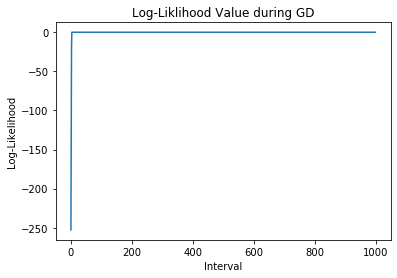

In [397]:
plt.plot(vals)
plt.title("Log-Liklihood Value during GD")
plt.xlabel("Interval")
plt.ylabel("Log-Likelihood");

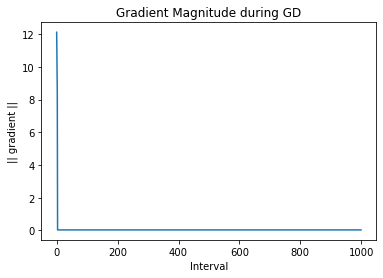

In [398]:
plt.plot(grads)
plt.title("Gradient Magnitude during GD")
plt.xlabel("Interval")
plt.ylabel("|| gradient ||");

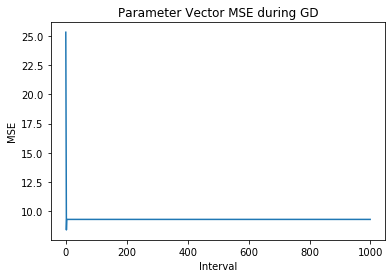

In [399]:
plt.plot(mse)
plt.title("Parameter Vector MSE during GD")
plt.xlabel("Interval")
plt.ylabel("MSE");

In [400]:
grads[-1]

0.03039142310609717

In [401]:
print("True w     Calc w")
for i in range(len(w)):
    print("{:.4f}     {:.4f}".format(w[i], w_calc[i]))

True w     Calc w
3.5355     7.0184
3.5355     12.1347


## Numerically Compute CRLB

In [402]:
def crlb(n, w, X_variance):
    X, y, w = generate_observations(w, 100000, X_variance)
    d = X.shape[1]
    z = np.exp(X@w)
    p = z/(1+z)
    I = np.zeros((d, d))
    for i in range(len(X)):
        x = X[i][:,np.newaxis]
        I += p[i] * (1-p[i]) * x @ x.T
    I /= 100000
    return np.linalg.inv(n*I)

## Compute Covariance for Estimated Parameters

In [403]:
def run_monte_carlo(num_observations, X_variance, mode='gd', lr=0.001, max_iter=1000):
    dimensions = 2
    w = (5/np.sqrt(2))*np.array([1, 1])
    trials = 200

    mse_mat = np.zeros((dimensions, dimensions))
    for i in range(trials):
        X, y, w = generate_observations(w, num_observations, X_variance)

        if mode=='gd':
            w_calc, vals, grads, mse = do_gd(X, y, w, lr, max_iter)
        elif mode =='newton':
            w_calc, _, _,_, _ = do_newton(X, y, w, lr, max_iter)
        else:
            raise NotImplemented
            
        e = w - w_calc
        mse_mat += e[:,np.newaxis] @ e[:,np.newaxis].T

    mse_mat /= trials
    return (np.trace(mse_mat), np.trace(crlb(num_observations, w, X_variance)))

10
20
50
80
200
300


/home/luc/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


500
700
1000


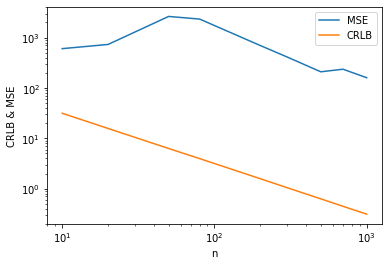

In [404]:
X_variance = 10
ns = [10, 20, 50, 80, 200, 300, 500, 700, 1000]
mses = []
crlbs = []
for n in ns:
    print(n, flush=True)
    m, c = run_monte_carlo(n, X_variance, max_iter=500)
    mses.append(m)
    crlbs.append(c)

plt.plot(ns, mses, label="MSE")
plt.plot(ns, crlbs, label="CRLB")
plt.ylabel("CRLB & MSE")
plt.xlabel("n")
plt.xscale('log')
plt.yscale('log')
plt.legend();

10
20
50
80
200
300
500
700
1000


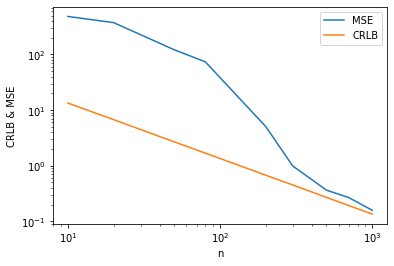

In [354]:
X_variance = 1
ns = [10, 20, 50, 80, 200, 300, 500, 700, 1000]
mses = []
crlbs = []
for n in ns:
    print(n, flush=True)
    m, c = run_monte_carlo(n, X_variance, max_iter=100)
    mses.append(m)
    crlbs.append(c)

plt.plot(ns, mses, label="MSE")
plt.plot(ns, crlbs, label="CRLB")
plt.ylabel("CRLB & MSE")
plt.xlabel("n")
plt.xscale('log')
plt.yscale('log')
plt.legend();

# Newton Method 

In [331]:
def second_grad_log_likelihood(X, w):
    d = X.shape[1]
    z = np.exp(X @ w)
    p = z / (1 + z)
    I = np.zeros((d, d))
    for i in range(len(X)):
        x = X[i][:, np.newaxis]
        I += p[i] * (1 - p[i]) * x @ x.T
    return I

In [332]:
def do_newton(X, y, true_w, lr=0.001, max_iter=1000):
    vals = []
    grads, second_grads = [], []
    mse = []
    w = 10 * np.random.rand(X.shape[1]) - 5
    grad = grad_log_likelihood(X, y, w)
    second_grad = second_grad_log_likelihood(X, w)
    second_grad_inv = np.linalg.inv(second_grad)

    count = 0
    while count < max_iter:
        vals.append(log_likelihood(X, y, w))

        grads.append(np.linalg.norm(grad))
        second_grads.append(np.linalg.norm(second_grad))

        mse.append(np.linalg.norm(w - true_w, ord=2))
        w += lr * (second_grad_inv @ grad)

        grad = grad_log_likelihood(X, y, w)
        second_grad = second_grad_log_likelihood(X, w)
        second_grad_inv = np.linalg.inv(second_grad)
        count += 1
    return w, vals, grads, second_grads, mse

In [333]:
w_calc, vals, grads, second_grads, mse = do_newton(X, y, w, lr=0.001, max_iter=10000)

# Plot Results of Newton Method



In [334]:
print("True w     Calc w")
for i in range(len(w)):
    print("{:.4f}     {:.4f}".format(w[i], w_calc[i]))

True w     Calc w
3.5355     24.9550
3.5355     52.4097


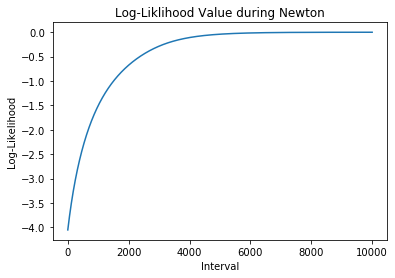

In [335]:
plt.plot(vals)
plt.title("Log-Liklihood Value during Newton")
plt.xlabel("Interval")
plt.ylabel("Log-Likelihood");

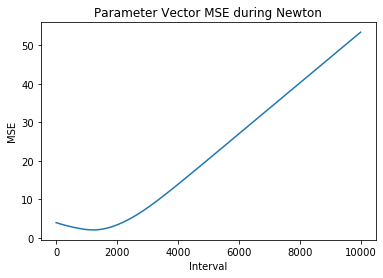

In [336]:
plt.plot(mse)
plt.title("Parameter Vector MSE during Newton")
plt.xlabel("Interval")
plt.ylabel("MSE");

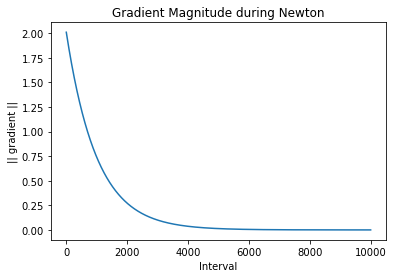

In [337]:
plt.plot(grads)
plt.title("Gradient Magnitude during Newton")
plt.xlabel("Interval")
plt.ylabel("|| gradient ||");

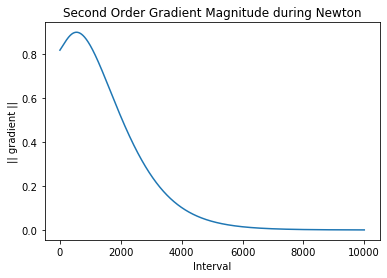

In [338]:
plt.plot(second_grads)
plt.title("Second Order Gradient Magnitude during Newton")
plt.xlabel("Interval")
plt.ylabel("|| gradient ||");

In [ ]:
X_variance = 10
ns = [10, 20, 50, 80, 200, 300, 500, 700, 1000, 5000]
mses = []
crlbs = []
for n in ns:
    m, c = run_monte_carlo(n, X_variance, mode='newton',lr=0.001, max_iter=10000)
    mses.append(m[0])
    crlbs.append(c[0])

plt.plot(ns, mses, label="MSE")
plt.plot(ns, crlbs, label="CRLB")
plt.ylabel("CRLB & MSE")
plt.xlabel("n")
plt.xscale('log')
plt.yscale('log')
plt.legend();

/Users/anuragkoul/opt/miniconda3/envs/dream-and-search/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in exp
  
/Users/anuragkoul/opt/miniconda3/envs/dream-and-search/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/Users/anuragkoul/opt/miniconda3/envs/dream-and-search/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/anuragkoul/opt/miniconda3/envs/dream-and-search/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
